In [2]:
#from Preprocess import train_dataset, val_dataset, test_dataset, amazon_training_image_paths, amazon_validation_image_paths, amazon_test_image_paths, batches

import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation, LeakyReLU, Dropout, Input, Lambda, Add, Conv2DTranspose, Concatenate, Reshape, Permute, Multiply, GlobalAveragePooling2D, Dense, Flatten

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score
import tensorflow.keras.backend as K
#from hyperparameters import alpha
K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model

In [3]:
import _models_utils
from tensorflow.keras import callbacks

# -------------------- load data

augment = True
train_dataset, val_dataset, test_dataset = _models_utils.load_datasets(use_augmentation = augment)

# ----------- create directories

out_dir = '../results/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '_UNET_ATTN/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    os.makedirs(out_dir + '/plots')
    os.makedirs(out_dir + '/weights')
    os.makedirs(out_dir + '/predictions')

checkpoint = callbacks.ModelCheckpoint(
    filepath=out_dir + 'weights/' + 'model.{epoch:02d}-{val_loss:.4f}.weights.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max', 
    verbose=1
)

In [4]:
def conv2d_block(input_tensor,
                 n_filters,
                 kernel_size=3,
                 batchnorm=True,
                 strides=1,
                 dilation_rate=1,
                 recurrent=1):

    # A wrapper of the Keras Conv2D block to serve as a building block for downsampling layers
    # Includes options to use batch normalization, dilation and recurrence

    conv = Conv2D(filters=n_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  kernel_initializer="he_normal",
                  padding="same",
                  dilation_rate=dilation_rate)(input_tensor)
    if batchnorm:
        conv = BatchNormalization()(conv)
    output = LeakyReLU(alpha=0.3)(conv)

    for _ in range(recurrent - 1):
        conv = Conv2D(filters=n_filters,
                      kernel_size=kernel_size,
                      strides=1,
                      kernel_initializer="he_normal",
                      padding="same",
                      dilation_rate=dilation_rate)(output)
        if batchnorm:
            conv = BatchNormalization()(conv)
        res = LeakyReLU(alpha=0.3)(conv)
        output = Add()([output, res])

    return output

def transpose_block(input_tensor,
                    skip_tensor,
                    n_filters,
                    kernel_size=3,
                    strides=1,
                    batchnorm=True,
                    recurrent=1):

    # A wrapper of the Keras Conv2DTranspose block to serve as a building block for upsampling layers

    shape_x = K.int_shape(input_tensor)
    shape_xskip = K.int_shape(skip_tensor)

    conv = Conv2DTranspose(filters=n_filters,
                           kernel_size=kernel_size,
                           padding='same',
                           strides=(shape_xskip[1] // shape_x[1],
                                    shape_xskip[2] // shape_x[2]),
                           kernel_initializer="he_normal")(input_tensor)
    conv = LeakyReLU(alpha=0.3)(conv)

    act = conv2d_block(conv,
                       n_filters=n_filters,
                       kernel_size=kernel_size,
                       strides=1,
                       batchnorm=batchnorm,
                       dilation_rate=1,
                       recurrent=recurrent)
    output = Concatenate(axis=3)([act, skip_tensor])
    return output

def expend_as(tensor, rep):

    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2

    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                       arguments={'repnum': rep})(tensor)
    return my_repeat

def AttnGatingBlock(x, g, inter_shape):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=1,
                   strides=1,
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=(shape_x[1] // shape_g[1],
                              shape_x[2] // shape_g[2]),
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
    # add_xg = Add([phi_g, theta_x])
    add_xg = Add()([phi_g, theta_x])

    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],
                                             shape_x[2] //
                                             shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, shape_x[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=shape_x[3],
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    return output


def GatingSignal(input_tensor, batchnorm=True):

    # 1x1x1 convolution to consolidate gating signal into the required dimensions
    # Not required most of the time, unless another ReLU and batch_norm is required on gating signal

    shape = K.int_shape(input_tensor)
    conv = Conv2D(filters=shape[3],
                  kernel_size=1,
                  strides=1,
                  padding="same",
                  kernel_initializer="he_normal")(input_tensor)
    if batchnorm:
        conv = BatchNormalization()(conv)
    output = LeakyReLU(alpha=alpha)(conv)
    return output

In [5]:
def Attention_U_network(input_shape, n_filters=16, batchnorm=True):

    inputs = tf.keras.Input(input_shape)
    
    # encoder
    
    c0 = conv2d_block(inputs,
                 n_filters=n_filters,
                 kernel_size=3,
                 batchnorm=batchnorm,
                 strides=1,
                 dilation_rate=1,
                 recurrent=2) # 256x256x256
    
    p0 = MaxPooling2D((2,2))(c0)
    p0 = Dropout(0.4)(p0)
    
    c1 = conv2d_block(p0,
                 n_filters=n_filters * 2,
                 kernel_size=3,
                 batchnorm=batchnorm,
                 strides=1,
                 dilation_rate=1,
                 recurrent=2) # 128x128x128
    
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(0.4)(p1)
    
    c2 = conv2d_block(p1,
                 n_filters=n_filters * 4,
                 kernel_size=3,
                 batchnorm=batchnorm,
                 strides=1,
                 dilation_rate=1,
                 recurrent=2) # 64x64x64
    
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(0.4)(p2)

    c3 = conv2d_block(p2,
                 n_filters=n_filters * 8,
                 kernel_size=3,
                 batchnorm=batchnorm,
                 strides=1,
                 dilation_rate=1,
                 recurrent=2) # 32x32x32
    
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(0.4)(p3)

    # bridge
    
    b0 = conv2d_block(p3,
                 n_filters=n_filters * 16,
                 kernel_size=3,
                 batchnorm=batchnorm,
                 strides=1,
                 dilation_rate=1,
                 recurrent=2) # 16x16x16

    # decoder

    attn0 = AttnGatingBlock(c3, b0, n_filters * 16)
    u0 = transpose_block(b0,
                         attn0,
                         n_filters=n_filters * 8,
                         batchnorm=batchnorm,
                         recurrent=2)  # 32x32x32

    attn1 = AttnGatingBlock(c2, u0, n_filters * 8)
    u1 = transpose_block(u0,
                         attn1,
                         n_filters=n_filters * 4,
                         batchnorm=batchnorm,
                         recurrent=2)  # 64x64x64

    attn2 = AttnGatingBlock(c1, u1, n_filters * 4)
    u2 = transpose_block(u1,
                         attn2,
                         n_filters=n_filters * 2,
                         batchnorm=batchnorm,
                         recurrent=2)  # 128x128x128

    u3 = transpose_block(u2,
                         c0,
                         n_filters=n_filters,
                         batchnorm=batchnorm,
                         recurrent=2)  # 256x256x256

    outputs = Conv2D(filters=1, kernel_size=1, strides=1,
                     activation='sigmoid')(u3)
    model = Model(inputs=inputs, outputs=[outputs])
    return model

In [6]:
input_shape = (256, 256, 4)
model = Attention_U_network(input_shape, batchnorm=True)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[checkpoint])

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.8544
Epoch 1: val_accuracy improved from -inf to 0.73291, saving model to ../results/2024-11-11_15-11-44_UNET_ATTN/weights\model.01-1.4725.weights.h5
125/125 [==============================] - 31s 200ms/step - loss: 0.3323 - accuracy: 0.8544 - val_loss: 1.4725 - val_accuracy: 0.7329
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.8845
Epoch 2: val_accuracy improved from 0.73291 to 0.94497, saving model to ../results/2024-11-11_15-11-44_UNET_ATTN/weights\model.02-0.1499.weights.h5
125/125 [==============================] - 23s 180ms/step - loss: 0.2757 - accuracy: 0.8845 - val_loss: 0.1499 - val_accuracy: 0.9450
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.8887
Epoch 3: val_accuracy did not improve from 0.94497
125/125 [==============================] - 22s 179ms/step - loss: 0.2666 - accuracy: 0.8887 - val_lo

In [7]:
# ---------------------- save results

# load best model
import glob
import os
# Cargar el último modelo guardado de forma dinámica
try:
    # Buscar todos los archivos de pesos en la carpeta
    weight_files = glob.glob(out_dir + 'weights/*.weights.h5')
    
    if weight_files:
        # Seleccionar el archivo más reciente basado en la fecha de creación/modificación
        latest_weights = max(weight_files, key=os.path.getctime)
        print(f"Cargando el modelo más reciente desde: {latest_weights}")
        
        # Cargar los pesos
        model.load_weights(latest_weights)
        print("Pesos cargados exitosamente.")
    else:
        print("No se encontraron archivos de pesos en el directorio especificado.")
except FileNotFoundError:
    print("No se encontró el archivo de pesos. Verifica la ruta o el nombre del archivo.")
except Exception as e:
    print(f"Ocurrió un error al cargar los pesos: {str(e)}")

Cargando el modelo más reciente desde: ../results/2024-11-11_15-11-44_UNET_ATTN/weights\model.13-0.1412.weights.h5
Pesos cargados exitosamente.


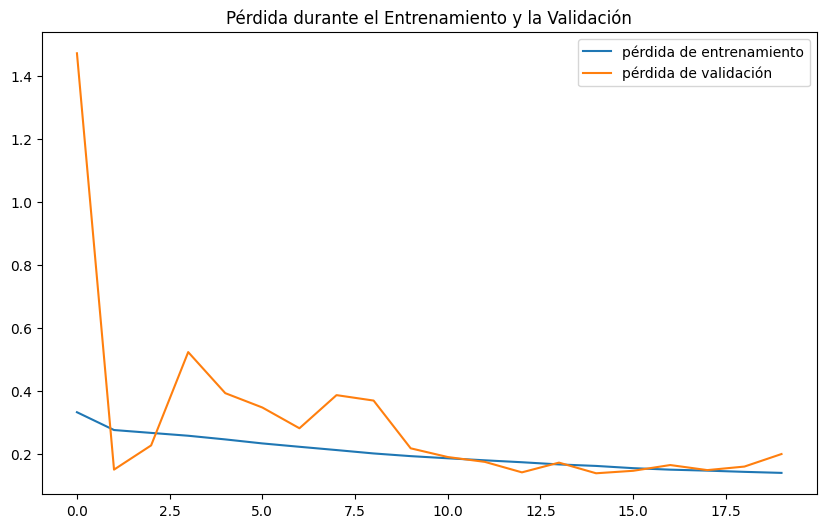

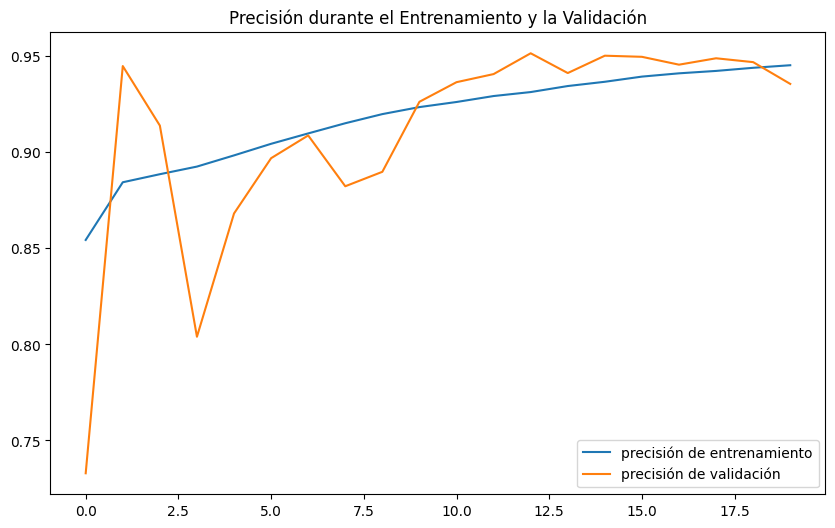

In [8]:

# Graficamos la pérdida (loss) del entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='pérdida de entrenamiento')  # Gráfica de la pérdida en entrenamiento
plt.plot(history.history['val_loss'], label='pérdida de validación')  # Gráfica de la pérdida en validación
plt.title('Pérdida durante el Entrenamiento y la Validación')
plt.legend()

# Guardamos la gráfica de pérdida en el directorio correspondiente
plt.savefig(os.path.join(out_dir, 'plots', 'loss.png'))
plt.show()

# Graficamos la precisión (accuracy) del entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='precisión de entrenamiento')  # Gráfica de la precisión en entrenamiento
plt.plot(history.history['val_accuracy'], label='precisión de validación')  # Gráfica de la precisión en validación
plt.title('Precisión durante el Entrenamiento y la Validación')
plt.legend()

# Guardamos la gráfica de precisión en el directorio correspondiente
plt.savefig(os.path.join(out_dir, 'plots', 'accuracy.png'))
plt.show()

In [12]:
# save model
from _models_utils import show_and_save_predictions

model.save(out_dir + '/weights/' + 'final_model.h5')

for i in range(80):
    show_and_save_predictions(i, test_dataset, model, out_dir)


1/1 [==============================] - 0s 29ms/step


In [13]:

# ----------- save metrics
import _models_utils
if augment:
    augmetation_settings = {
    "flip_left_right": 0,
    "flip_up_down": 0,
    "gaussian_blur": 0.2,
    "random_noise": 0.0,
    "random_brightness": 0.5,
    "random_contrast": 0.5}
else:
    augmetation_settings = None

batches = 16
shuffled = True

model_info = _models_utils.evaluate_model(
    "U-net attention; final dataset", 
    test_dataset,
    model, 
    input_shape, 
    shuffled, 
    batches, 
    epochs, 
    augment_settings=augmetation_settings, 
    threshold=0.5
    )
df = pd.DataFrame(model_info)
df.to_csv(os.path.join(out_dir, 'metrics.csv'), index=False)

1/1 [==============================] - 0s 42ms/step
